In [1]:
import xgboost as xgb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.feature_selection import SelectKBest,f_classif, SelectFromModel, RFECV
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import Lasso


# 0) Load Dataset

In [9]:
# Load train and test data
train_df = pd.read_csv("../../data/train_data.csv")
test_df = pd.read_csv("../../data/test_data.csv")

In [10]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

# Randomly sample test dataset
print(f"Fraud proportion in original test data: {test_df['is_fraud'].mean()}")

test_not_fraud = test_df.loc[test_df['is_fraud'] == 0].sample(22000, random_state = 123)
test_fraud = test_df.loc[test_df['is_fraud'] == 1].sample(100, random_state = 123)
test_sample_df = pd.concat([test_fraud, test_not_fraud])

print(f"Fraud proportion in sample test dataset: {test_sample_df['is_fraud'].mean()}")

X_test = test_sample_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_sample_df['is_fraud']
print(f"Size of test dataset: {len(y_test)}")

Fraud proportion in original test data: 0.0032388145877671527
Fraud proportion in sample test dataset: 0.004524886877828055
Size of test dataset: 22100


In [11]:
X_train.dtypes

gender            object
state             object
zip                int64
city_pop           int64
job               object
category          object
amt              float64
hour               int64
day_of_week       object
month             object
trans_quarter     object
year               int64
age                int64
dtype: object

In [12]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Resampling
# Step 1: Undersample
undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
x_under, y_under = undersampler.fit_resample(X_train, y_train)

# Step 2: Oversample with SMOTENC
smotenc = SMOTENC(categorical_features=categorical_columns_idx, 
                  random_state=123, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = smotenc.fit_resample(x_under, y_under)

preprocessor=ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
        ('num', MinMaxScaler(), numerical_columns)
    ]
)

# 1) XGBoost without CV & feature selection

In [13]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


In [14]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


## Encode and Standardise

In [15]:
# Apply one-hot encoding on train and test data
X_train_ohe = pd.get_dummies(X_train_smote)
X_test_ohe = pd.get_dummies(X_test)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

# Stardardise data
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

Number of columns after one-hot encoding: 534


c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:15:25] WARNING: D:\bld\xgboost-split_1744352332375\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 score: 0.0126
AUC score: 0.6281


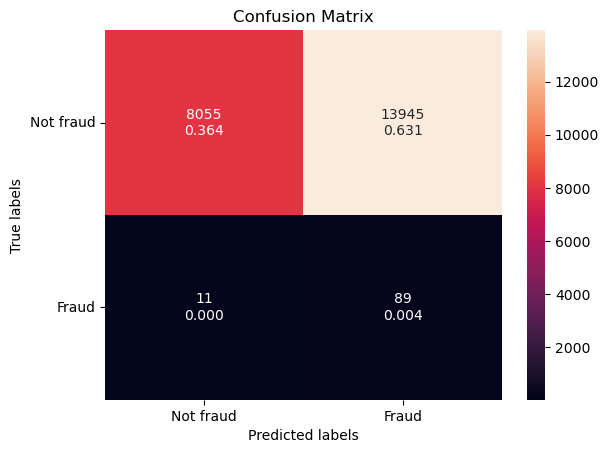

In [17]:


# xgb_train = xgb.DMatrix(X_train_kbest, y_train_smote, enable_categorical=True)
# xgb_test = xgb.DMatrix(X_test, y_test_smote, enable_categorical=True)
n=50
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model.fit(X_train_scaled, y_train_smote)

# TO FIX: apply selected features to test data
y_pred = xgb_model.predict(X_test_scaled)

# a) f1_score
f1 = f1_score(y_test, y_pred)
print(f"F1 score: {f1:.4f}")


# b) auc score
auc = roc_auc_score(y_test, y_pred)
print(f"AUC score: {auc:.4f}")

# c) confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Plot confusion matrix
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

# 2a) GridSearchCV + Group Lasso

In [18]:
# Pipeline for each fold
pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),
    ('model', xgb.XGBClassifier(use_label_encoder=False))
])

# Define the hyperparameter grid
param_grid = {
    'model__max_depth': [3, 5, 8],
    'model__learning_rate': [0.1],
    'model__subsample': [0.3, 0.5, 0.8],
    'model__scale_pos_weight': [1],
    'model__eta':[0.1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', error_score='raise')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_resampled, y_train_resampled)


c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:37] WARNING: D:\bld\xgboost-split_1744352332375\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:48] WARNING: D:\bld\xgboost-split_1744352332375\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:59] WARNING: D:\bld\xgboost-split_1744352332375\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:20:10] WARNING: D:\bld\xgboost-split_1744352332375\work\src\learner.cc:738: 
Parameters: { "

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         Index(['gender', 'state', 'job', 'category', 'day_of_week', 'month',
       'trans_quarter'],
      dtype='object')),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         Index(['zip', 'city_pop', 'amt', 'hour', 'year', 'age'], dt...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'model__eta': [0.1], 'model__learning_rate': [0.1],
                         'model__max_depth': [3, 5, 8],
                         'model__scale_pos_weight': [1],
                         'model__subsample': [0.3, 0.5, 0.8]},
             scoring='f1')

## Evaluating model performance

In [19]:
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best f1 score: ", grid_search.best_score_)

# Get best model and test performance
best_model = grid_search.best_estimator_

## ADDTIONAL EVALUATION METRICS(on top of F1 score) ON VALIDATION SET ##
# a) Compute AUC score (using probabilities for positive class)
auc_scores = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print(f"Mean AUC: {auc_scores.mean():.4f}")

Best set of hyperparameters:  {'model__eta': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__scale_pos_weight': 1, 'model__subsample': 0.5}
Best f1 score:  0.9599194372874674


c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:03] WARNING: D:\bld\xgboost-split_1744352332375\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:16] WARNING: D:\bld\xgboost-split_1744352332375\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:34] WARNING: D:\bld\xgboost-split_1744352332375\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:47] WARNING: D:\bld\xgboost-split_1744352332375\work\src\learner.cc:738: 
Parameters: { "

Mean AUC: 0.9950


### Confusion matrix

In [ ]:
# b) Confusion matrix
# ax= plt.subplot()
# cm = confusion_matrix(y_test, y_pred)

# # Format text in boxes
# group_counts = ["{0:g}".format(value) for value in
#                 cm.flatten()]
# group_percentages = ["{0:.3f}".format(value) for value in
#                      cm.flatten()/np.sum(cm)]
# values = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_counts,group_percentages)]
# values = np.asarray(values).reshape(2, 2)

# # Plot confusion matrix
# sns.heatmap(cm, annot=values, fmt='')
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
# ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
# plt.show()


## Selected features

In [20]:
# access Lasso step from pipeline
selector=best_model.named_steps['feature_selection']

feature_names= best_model.named_steps['preprocessor'].get_feature_names_out()
selected_features=feature_names[selector.get_support()]
print("Selected features: ", selected_features)

Selected features:  ['cat__gender_F' 'cat__state_CA' 'cat__job_Designer'
 'cat__category_entertainment' 'cat__category_food_dining'
 'cat__category_grocery_net' 'cat__category_grocery_pos'
 'cat__category_health_fitness' 'cat__category_kids_pets'
 'cat__category_misc_net' 'cat__category_misc_pos'
 'cat__category_personal_care' 'cat__category_shopping_net'
 'cat__category_shopping_pos' 'cat__category_travel'
 'cat__day_of_week_Friday' 'cat__day_of_week_Saturday'
 'cat__day_of_week_Sunday' 'cat__day_of_week_Thursday'
 'cat__day_of_week_Tuesday' 'cat__day_of_week_Wednesday'
 'cat__month_2021-02-01' 'cat__month_2021-04-01' 'cat__month_2021-06-01'
 'cat__month_2021-08-01' 'cat__month_2021-10-01' 'cat__month_2021-12-01'
 'cat__month_2022-03-01' 'cat__month_2022-04-01' 'cat__month_2022-07-01'
 'cat__month_2022-09-01' 'cat__month_2022-11-01'
 'cat__trans_quarter_2021Q1' 'cat__trans_quarter_2021Q3'
 'cat__trans_quarter_2021Q4' 'cat__trans_quarter_2022Q2'
 'cat__trans_quarter_2022Q3' 'cat__trans

# 2b) GridSearchCV + selectkbest

In [ ]:

# Identify categorical and numerical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Get indices of categorical columns for SMOTENC
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', MinMaxScaler(), numerical_columns)
    ]
)

# Resampling
# Step 1: Undersample
undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
x_under, y_under = undersampler.fit_resample(X_train, y_train)

# Step 2: Oversample with SMOTENC
smotenc = SMOTENC(categorical_features=categorical_columns_idx, 
                  random_state=123, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = smotenc.fit_resample(x_under, y_under)


# Pipeline with feature selection, and model
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=20)),
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(use_label_encoder=False))
])

# Hyperparameter grid
# param_grid = {
#     'model__max_depth': [5, 8],
#     'model__learning_rate': [0.1],
#     'model__subsample': [0.5, 0.7],
#     'model__scale_pos_weight': [1, 2]
# }
param_grid = {
    'model__max_depth': [3, 5, 8],
    'model__learning_rate': [0.1],
    'model__subsample': [0.3, 0.5, 0.8],
    'model__scale_pos_weight': [1],
    'model__eta':[0.1]
}

# GridSearchCV setup
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', error_score='raise')

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Print best parameters and score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best f1 score: ", grid_search.best_score_)


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [22:35:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [22:35:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [22:36:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [22:36:47] WARNING: C:\actions-r

Best set of hyperparameters:  {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__scale_pos_weight': 1, 'model__subsample': 0.7}
Best score:  0.914411225903112


validation f1_score: {'mean_fit_time': array([25.81950459, 24.14988718, 34.28219686, 28.42363138, 12.65716105,
       14.07678952, 14.30344596, 14.43473969, 19.023948  , 15.22082934,
       14.37859735, 14.57768879, 13.92704239, 15.0493526 , 17.50361738,
       22.59106359, 14.57657561, 15.04521689]), 'std_fit_time': array([ 7.02522605,  8.74157762,  1.04815385, 10.48297463,  0.18302783,
        2.1628887 ,  0.53379011,  1.2937283 ,  6.43112781,  0.56130558,
        0.55237437,  0.40520487,  0.85745237,  0.73348196,  5.56463998,
        9.90996761,  0.60579746,  0.85570548]), 'mean_score_time': array([3.75752788, 2.65864158, 4.16102076, 3.68405757, 1.52017789,
       1.67772217, 1.85279183, 1.85587497, 2.3522449 , 1.827388  ,
       1.83140545, 1.88121076, 1.67696662, 1.79237599, 2.31343422,
       2.3412971 , 1.76768198, 2.04913969]), 'std_score_time': array([0.97310632, 1.13311699, 0.26837491, 1.62050913, 0.07755836,
       0.12270924, 0.18723273, 0.20662515, 1.11465299, 0.13678458,


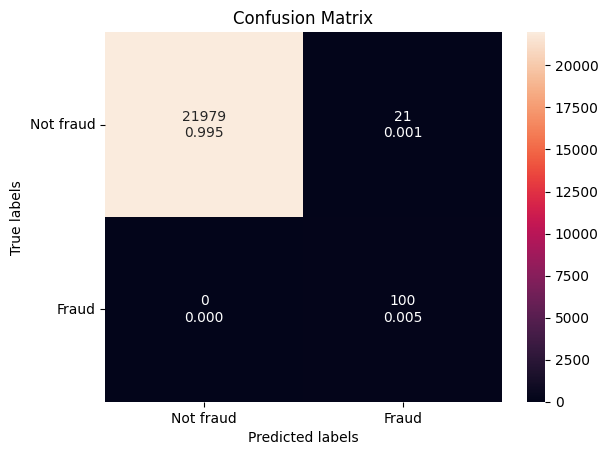

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:11] WARNING: C:\actions-r

Mean AUC: 0.9982


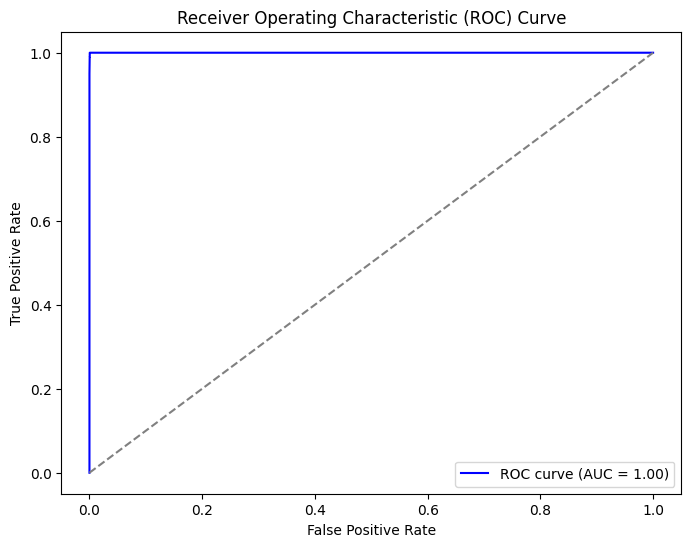

In [ ]:

# Get best model and test performance
best_model = grid_search.best_estimator_
f1_score = grid_search.cv_results_
print('validation f1_score:', f1_score)

# Make predictions on the test set
y_pred = best_model.predict(X_test)  # Predicted labels (X_test is transformed by the pipeline)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class (for AUC)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
# disp.plot(cmap=plt.cm.Blues)
# plt.show()


ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Plot confusion matrix
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()


# Compute AUC score (using probabilities for positive class)
auc_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Mean AUC: {auc_scores.mean():.4f}")

# 4) RFECV

## Evaluating model performance

In [ ]:
rfecv = RFECV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc'),
    step=5,
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Pipeline for each fold
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', rfecv),
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc'))
])

# Evaluate using cross_validate
cv_results = cross_validate(
    pipeline,
    X_train_resampled,
    y_train_resampled,
    scoring={'f1': 'f1', 'auc': 'roc_auc'},
    cv=StratifiedKFold(5),
    return_train_score=False,
    n_jobs=-1
)

# 6. Print detailed results
print("Validation F1 scores per fold:", cv_results['test_f1'])
print("Validation AUC scores per fold:", cv_results['test_auc'])


print("\nAverage Validation F1:", cv_results['test_f1'].mean())
print("Average Validation AUC:", cv_results['test_auc'].mean())


Validation F1 scores per fold: [0.90823015        nan        nan 0.97204478        nan]
Validation AUC scores per fold: [0.92047012        nan        nan 0.97851562        nan]

Average Validation F1: nan
Average Validation AUC: nan


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\jobl

### Confusion Matrix

In [ ]:
# # b) Confusion matrix
# ax= plt.subplot()
# cm = confusion_matrix(y_test, y_pred)

# # Format text in boxes
# group_counts = ["{0:g}".format(value) for value in
#                 cm.flatten()]
# group_percentages = ["{0:.3f}".format(value) for value in
#                      cm.flatten()/np.sum(cm)]
# values = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_counts,group_percentages)]
# values = np.asarray(values).reshape(2, 2)

# # Plot confusion matrix
# sns.heatmap(cm, annot=values, fmt='')
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
# ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
# plt.show()


## Selected features (in each fold)

In [ ]:
# Fit the pipeline on the entire training set
pipeline.fit(X_train_resampled, y_train_resampled)

# Extract the fitted RFECV step
rfecv_fitted = pipeline.named_steps['feature_selection']

# Get mask of selected features
selected_mask = rfecv_fitted.support_

# Get feature names after preprocessing
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get selected feature names
selected_features = np.array(feature_names)[selected_mask]

print(f"Optimal number of features: {rfecv_fitted.n_features_}")
print("Selected features: ", selected_features)

# 4b) IGNORE EVERYTHING BELOW

## PREDICTION OF TEST X

In [ ]:
# IGNORE FIRST
# ONLY FOR TEST SET
print('TEST SCORES')
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

# Fit final model on the reduced training set
final_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
final_model.fit(X_train_rfecv, y_train)

# Predict class labels
y_pred = final_model.predict(X_test_rfecv)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
# disp.plot(cmap=plt.cm.Blues)
# plt.show()


ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Plot confusion matrix
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Compute AUC score (using probabilities for positive class)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc:.4f}")

# Optional: Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()